# PVAnalytics QA Process: Wind Speed

In [1]:
import pvanalytics
import numpy as np
import rdtools
from statistics import mode
import json
# pvanalytics.__version__
from pvanalytics.features.clearsky import reno       #update to just do a pvanalytics import?
import pvlib
import matplotlib.pyplot as plt
import pandas as pd
from pvanalytics.quality import data_shifts as ds
from pvanalytics.quality import gaps
from pvanalytics.quality.outliers import zscore
from pvanalytics.features.daytime import power_or_irradiance
from pvanalytics.quality.time import shifts_ruptures
from pvanalytics.features import daytime
from pvanalytics.system import (is_tracking_envelope,
                                infer_orientation_fit_pvwatts)
from pvanalytics.features.clipping import geometric
from pvanalytics.features.clearsky import reno
import ruptures as rpt
import os

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })

In the following example, a process for assessing the data quality of a wind speed data stream is shown, using PVAnalytics functions. These example pipelines illustrates how several PVAnalytics functions can be used in sequence to assess the quality of a wind speed data stream.

First, we download and import the wind speed data stream from a PV installation under the [2023 solar data prize data set](https://data.openei.org/s3_viewer?bucket=oedi-data-lake&limit=100&prefix=pvdaq%2F2023-solar-data-prize%2F). This data set is publicly available via the PVDAQ database in the DOE Open Energy Data Initiative (OEDI) (https://data.openei.org/submissions/4568), under system ID 2107. This data is timezone-localized.

In [2]:
with open('2107_system_metadata.json', 'r') as f:
    metadata = json.load(f)

In [3]:
tz = metadata['System']['timezone_code']

In [4]:
def parse_prize_csv(file, tz):
    df = pd.read_csv(file)
    df.index = pd.to_datetime(df['measured_on'])
    df.index = df.index.tz_localize(tz, ambiguous='NaT')
    df = df.loc[df.index.dropna()].copy()
    print(f'{file} {df.index.min()}:{df.index.max()}')
    return df

In [5]:
df_env = parse_prize_csv('2107_environment_data.csv', tz)

latitude = metadata['Site']['latitude']
longitude = metadata['Site']['longitude']

# Get wind speed column and turn it into a series
wind_time_series = df_env['wind_speed_o_149576']

2107_environment_data.csv 2017-12-01 00:00:00-08:00:2023-10-31 23:45:00-07:00


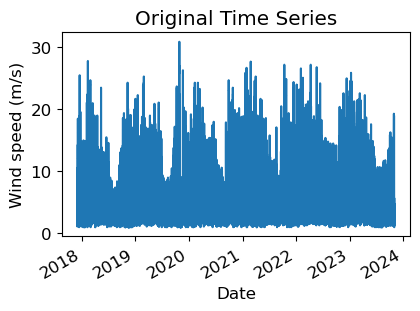

In [6]:
wind_time_series.plot(title="Original Time Series")
plt.xlabel("Date")
plt.ylabel("Wind speed (m/s)")
plt.show()

# Run Basic Data Checks

Now, let’s run basic data checks to identify stale and abnormal/outlier data in the time series. Basic data checks include the following steps:

1. Flatlined/stale data periods [(pvanalytics.quality.gaps.stale_values_round()).](https://pvanalytics--202.org.readthedocs.build/en/202/generated/pvanalytics.quality.gaps.stale_values_round.html#pvanalytics.quality.gaps.stale_values_round)

2. Outliers, which are defined as more than one 4 standard deviations away from the mean [(pvanalytics.quality.outliers.zscore()).](https://pvanalytics--202.org.readthedocs.build/en/202/generated/pvanalytics.quality.outliers.zscore.html#pvanalytics.quality.outliers.zscore)

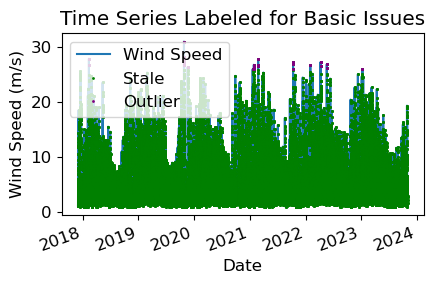

In [7]:
# REMOVE STALE DATA
stale_data_mask = gaps.stale_values_round(wind_time_series,
                                          window=3,
                                          decimals=2, mark = "tail")

# FIND OUTLIERS (Z-SCORE FILTER)
zscore_outlier_mask = zscore(wind_time_series,
                             zmax=5,
                             nan_policy='omit')

# Get the percentage of data flagged for each issue, so it can later be logged
pct_stale = round((len(wind_time_series[
    stale_data_mask].dropna())/len(wind_time_series.dropna())*100), 1)
pct_outlier = round((len(wind_time_series[
    zscore_outlier_mask].dropna())/len(wind_time_series.dropna())*100), 1)

# Visualize all of the time series issues (stale, abnormal, outlier)
wind_time_series.plot()
labels = ["Wind Speed"]
if any(stale_data_mask):
    wind_time_series.loc[stale_data_mask].plot(ls='',
                                          marker='o',
                                          color="green")
    labels.append("Stale")
if any(zscore_outlier_mask):
    wind_time_series.loc[zscore_outlier_mask].plot(ls='',
                                              marker='o',
                                              color="purple")
    labels.append("Outlier")
plt.legend(labels=labels)
plt.title("Time Series Labeled for Basic Issues")
plt.xticks(rotation=20)
plt.xlabel("Date")
plt.ylabel(f"Wind Speed (m/s)")
plt.tight_layout()
plt.show()


Now, let’s filter out any of the flagged data from the basic temperature checks (stale or abnormal data).

In [8]:
# Filter the time series, taking out all of the issues
issue_mask = ((~stale_data_mask) & (~zscore_outlier_mask))

wind_time_series = wind_time_series[issue_mask].copy()

# Daily Completeness Check

We filter the time series based on its daily completeness score. This filtering scheme requires at least 25% of data to be present for each day to be included.

In [9]:
# Get the time frequency of the time series
freq_minutes = int((mode(abs(np.diff(wind_time_series.index)))).total_seconds() / 60)
data_freq = str(freq_minutes) + "min"

wind_time_series = wind_time_series.asfreq(data_freq)

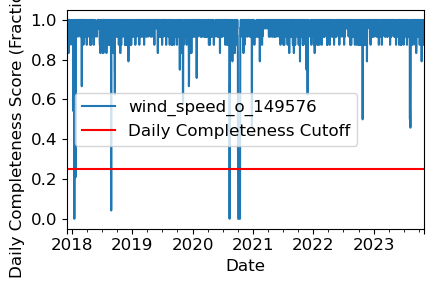

In [10]:
# Visualize daily data completeness
# Data frequency chaged to 60T due to duplicated data for every hr
# data_completeness_score = gaps.completeness_score(wind_time_series.asfreq("60T"))
data_completeness_score = gaps.completeness_score(wind_time_series)

# Visualize data completeness score as a time series.
data_completeness_score.plot()
plt.xlabel("Date")
plt.ylabel("Daily Completeness Score (Fractional)")
plt.axhline(y=0.25, color='r', linestyle='-',
            label='Daily Completeness Cutoff')
plt.legend()
plt.tight_layout()
plt.show()

# Trim the series based on daily completeness score
trim_series_mask = pvanalytics.quality.gaps.trim_incomplete(
    wind_time_series,
    minimum_completeness=.25,
    freq=data_freq)

wind_time_series = wind_time_series[trim_series_mask]

# Data/Capacity Shifts

Next, we check the time series for any abrupt data shifts. We take the longest continuous part of the time series that is free of data shifts. We use [pvanalytics.quality.data_shifts.detect_data_shifts()](https://pvanalytics--202.org.readthedocs.build/en/202/generated/pvanalytics.quality.data_shifts.detect_data_shifts.html#pvanalytics.quality.data_shifts.detect_data_shifts) to detect data shifts in the time series.

Shift Found:  False


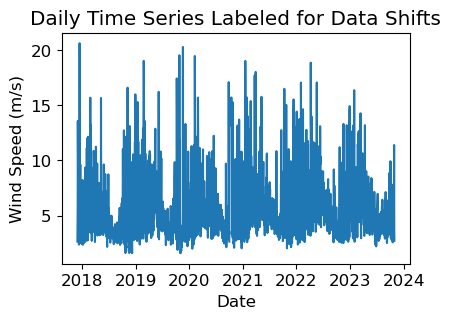

In [11]:
# Resample the time series to daily mean
wind_time_series_daily = wind_time_series.resample('D').mean()
data_shift_start_date, data_shift_end_date = \
    ds.get_longest_shift_segment_dates(wind_time_series_daily)
data_shift_period_length = (data_shift_end_date -
                            data_shift_start_date).days

# Get the number of shift dates
data_shift_mask = ds.detect_data_shifts(wind_time_series_daily)
# Get the shift dates
shift_dates = list(wind_time_series_daily[data_shift_mask].index)
if len(shift_dates) > 0:
    shift_found = True
else:
    shift_found = False

# Visualize the time shifts for the daily time series
print("Shift Found: ", shift_found)
edges = ([wind_time_series_daily.index[0]] + shift_dates +
         [wind_time_series_daily.index[-1]])
fig, ax = plt.subplots()
for (st, ed) in zip(edges[:-1], edges[1:]):
    ax.plot(wind_time_series_daily.loc[st:ed])
plt.title("Daily Time Series Labeled for Data Shifts")
plt.xlabel("Date")
plt.ylabel(f"Wind Speed (m/s)")
plt.show()

# Final Filtered Wind Speed Series

Finally, we filter the time series to only include the longest shift-free period. We then visualize the 
final time series post-QA filtering.

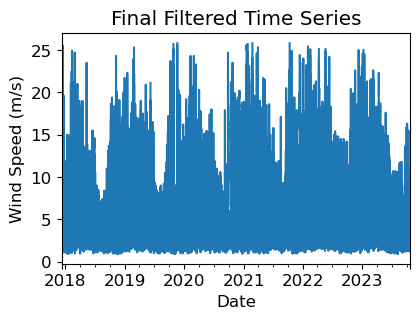

In [12]:
wind_time_series = wind_time_series[
    (wind_time_series.index >=
     data_shift_start_date.tz_convert(wind_time_series.index.tz)) &
    (wind_time_series.index <=
     data_shift_end_date.tz_convert(wind_time_series.index.tz))]

# Plot the final filtered time series.
wind_time_series.plot(title="Final Filtered Time Series")
plt.xlabel("Date")
plt.ylabel(f"Wind Speed (m/s)")
plt.show()

wind_time_series.to_pickle("./filtered_qa/wind_speed_o_149576.pkl")

Generate a dictionary output for the QA assessment of this data stream, including the percent stale and erroneous data detected, any shift dates, and the detected temperature units for the data stream.

In [13]:
qa_check_dict = {"pct_stale": pct_stale,
                 "pct_outlier": pct_outlier,
                 "data_shifts": shift_found,
                 "shift_dates": shift_dates}

print("QA Results:")
print(qa_check_dict)

QA Results:
{'pct_stale': 76.1, 'pct_outlier': 0.1, 'data_shifts': False, 'shift_dates': []}
